# importing the required libraries

In [1]:
from pathlib import Path
from collections import namedtuple
import numpy as np

from svspyed.utils.helper_functions import (
    check_csv_columns, get_layering_df, populate_layering_df,
)
from svspyed.input_preparation.prep_svs import ModelInputData
from svspyed.model.svs_model import SVSModel
from svspyed.ensemble_run.perturb_run import PerturbAndRun


# Variable definitions


In [25]:
# size of the ensemble
ENS_SIZE = 10

# (max) number of processors to use for parallelization
N_PROCS = 4

# random seed
RND_SEED = 1915

# relevant paths
paths = dict(
    # input meteorological data required to drive SVS
    hourly_meteo = Path(
        "/Users/alireza_amani/repos/svspyed/svspyed/tests/test_case_study/data/"
        "hourly_meteo.csv"
    ),

    # SVS executable (compiled from Fortran source code)
    svs_exec = Path(
        "/Users/alireza_amani/repos/MESH_SVS/svs_Nov7_"
    ),

    # the working dir where the run-time files will be stored
    working_dir = Path(
        "/Users/alireza_amani/repos/svspyed/svspyed/tests/test_case_study/"
    ),
)
# --------------------------------------------------------------------------- #

# a container for the properties of a soil type
SoilType = namedtuple("SoilType", [
    'code',
    'sand', 'clay',
    'wsat', 'wfc', 'wwilt',
    'ksat',
    'psisat', 'bcoef',
    'rhosoil',
])

# a container for a soil cover
Enclosure = namedtuple("Enclosure", [
    'layering',
    'soil_layers'
])

# a container for site-specific parameters required to configure SVS
SiteParams = namedtuple("SiteParams", [
    'deglat', 'deglng',
    'slop', 'zusl', 'ztsl',
    'observed_forcing', 'draindens', 'vf_type'
])

# a container for SVS internal parameters
SVSParams = namedtuple("SVSParams", [
    'SCHMSOL', 'lsoil_freezing_svs1', 'soiltext', 'read_user_parameters',
    'save_minutes_csv', 'water_ponding', 'KFICE', 'OPT_SNOW', 'OPT_FRAC',
    'OPT_LIQWAT', 'WAT_REDIS', 'tperm', 'user_wfcdp',
    "OPT_VEGFLUX", "OPT_AGGFLUX", "OPT_VEGCOND",
    "user_VEGDAT_INDEX", "user_VEGDAT_VALUE",
    "user_LAM_VEGL_STAB", "user_LAM_VEGL_UNSTAB",

])
# --------------------------------------------------------------------------- #


# checks #
# check if the paths lead to existing files/directories
for key, path in paths.items():
    if not path.exists():
        raise FileNotFoundError(f"{key} path does not exist: {path}")


# Setting up case study input object


In [26]:
# Cover Material soil
CMsoil = SoilType(
    code = "CM",
    sand = 66.2, clay = 7.7, # percent
    wsat = 0.329, wfc = 0.05, wwilt = 0.01, # volumetric fraction
    ksat = 9.49E-06, # m.s-1
    psisat = 0.34, bcoef = 1.48, # mH2O, unitless
    rhosoil=1604.91, # kg.m-3
)


E1 = Enclosure(
    layering    = "190:5:CM",
    soil_layers = [CMsoil],

    # "190:5:CM" -> 190 cm total depth, divided into 5 cm increments, each with
    # the properties of CMsoil
    # could be changed to, for example, `15:2.5:CM + 175:5:CM` to have a 15 cm
    # top layer with 2.5 cm increments, and a 175 cm bottom layer with 5 cm
)

# parameters describing the site, identical for all enclosures
site_params = SiteParams(
    deglat = 45.82, deglng = -72.37, # degrees latitude and longitude

    slop = 0.02, zusl = 10.0, ztsl = 1.5, # slope, heights for momentum and temp
    observed_forcing = "height", draindens = 0.0, vf_type = 13
    # drainage density, vegetation fraction type
)

# check SVS source code and doc for more info on these parameters
svs_params = SVSParams(
    SCHMSOL = "SVS", lsoil_freezing_svs1 = ".TRUE.", soiltext = "NIL",
    read_user_parameters = 1, save_minutes_csv = 0, water_ponding = 0,
    KFICE = 0, OPT_SNOW = 2, OPT_FRAC = 1, OPT_LIQWAT = 1, WAT_REDIS = 0,
    tperm = 280.15, user_wfcdp = 16.90 * 0.01,
    OPT_VEGFLUX = 3, OPT_AGGFLUX = 2, OPT_VEGCOND = 2,
    user_VEGDAT_INDEX = 13, user_VEGDAT_VALUE = 0.7,
    user_LAM_VEGL_STAB = 10.0, user_LAM_VEGL_UNSTAB = 10.0,
)

# name of the directory containing the enclosure
HOST_DIR_NAME = "test_run"

# mapping of the required meteo variables to the labels in the forcing file
# needed for the `save_csv_as_met` function
meteo_cols = {
    "utc_dtime": "datetime_utc",
    "air_temperature": "Air temperature (degC)",
    "precipitation": "Precipitation (mm)",
    "wind_speed": "Wind speed (m.s-1)",
    "atmospheric_pressure": "Atmospheric pressure (Pa)",
    "shortwave_radiation": "Shortwave radiation (W.m-2)",
    "longwave_radiation": "Longwave radiation (W.m-2)",
    "specific_humidity": "Specific humidity (kg.kg-1)",
    "relative_humidity": "Relative humidity (%)"
}


# simulation start_date
START_DATE = "2018-182-04-00"
END_DATE = "2020-182-04-00"

# spinup end date
SPINUP_END_DATE = "2019-07-01 00:00:00"

# spinup date timezone
SPINUP_END_DATE_TZ = "America/Montreal"

# name of the parameters to assign for each layer: all fields except `code`
layer_params = tuple(field for field in CMsoil._fields if field != 'code')

# --------------------------------------------------------------------------- #
# processing the information to create the required files # ----------------- #

# read layering information and populate the dataframe
dfenc = get_layering_df(E1)
dfenc = populate_layering_df(dfenc, E1, site_params)

input_object_deterministic = ModelInputData(
    work_dir_path=paths['working_dir'],
    soilcover_info=dfenc,
    metfile_path=paths['hourly_meteo'],
    exec_file_path=paths['svs_exec'],
    host_dir_name=HOST_DIR_NAME,
    meteo_col_names=meteo_cols,
    param_col_names={
        **{k: k for k in layer_params},
        **{k: k for k in site_params._fields},
    },
    model_params=svs_params._asdict(),
    start_date=START_DATE,
    end_date=END_DATE,
    spinup_end_date=SPINUP_END_DATE,
    time_zone=SPINUP_END_DATE_TZ,
)

test_svs = SVSModel(input_object_deterministic, True, True)

# Checks # ------------------------------------------------------------------ #
# check if the columns in the meteo file are correct
print("Checking meteo file columns...")
check_csv_columns(paths['hourly_meteo'], meteo_cols)



a folder named `test_run` is created inside the dir: `/Users/alireza_amani/repos/svspyed/svspyed/tests/test_case_study`


The `MESH_input_soil_levels.txt` file is created inside the host folder located at 
dir: `/Users/alireza_amani/repos/svspyed/svspyed/tests/test_case_study/test_run`.
In this file 38 soil layers are defined.


The `basin_forcing.met` is created inside the dir: `/Users/alireza_amani/repos/svspyed/svspyed/tests/test_case_study/test_run`


The MESH_input_run_options.ini is created inside the host folder
at: `/Users/alireza_amani/repos/svspyed/svspyed/tests/test_case_study/test_run`
Simulatuin start time (UTC): 2018-07-01 04:00:00
Simulatuin end time (UTC): 2020-06-30 04:00:00

MESH_parameters.txt created in the host folder at: `/Users/alireza_amani/repos/svspyed/svspyed/tests/test_case_study/test_run`

The SVS executable file is copied into the host folder. named `SVS_exe`.

SVSModel instance created.

Checking meteo file columns...
All columns found!


In [23]:
test_svs.mesh_param_file.parameters["OPT_VEGCOND"] = 1
test_svs.mesh_param_file.update_file()


MESH_parameters.txt updated.



In [30]:
test_svs.run_svs()
print(test_svs.run_process.stdout)


 MESH 1.4 ---  (1813)
 
 READING: MESH_input_run_options.ini
 READING: (creating basin for point mode)
   Total number of grids: 2
   Total number of grids inside the basin: 1
   Side length of grid: 1.00000000 m
   Number of GRUs: 1
   Number of land-based tiles: 1
 READING: MESH_input_soil_levels.txt
   Number of soil layers: 38
 READING: MESH_parameters.txt
   Active parameters in file: 30
 
 READING: Resume run configuration
   RESUMEFLAG is not active: RESUMEFLAG off
   SAVERESUMEFLAG is not active: SAVERESUMEFLAG off
 READING: basin_forcing.met
 
 
 The simulation starts at: 2018/07/01 04:00:00.000000
 Checking the start dates of the input files...
   Skipping 8760 records in 'basin_forcing.met'.
 
 RUNSVS is active: SVS                                                                                                                                                                                                                                                                        

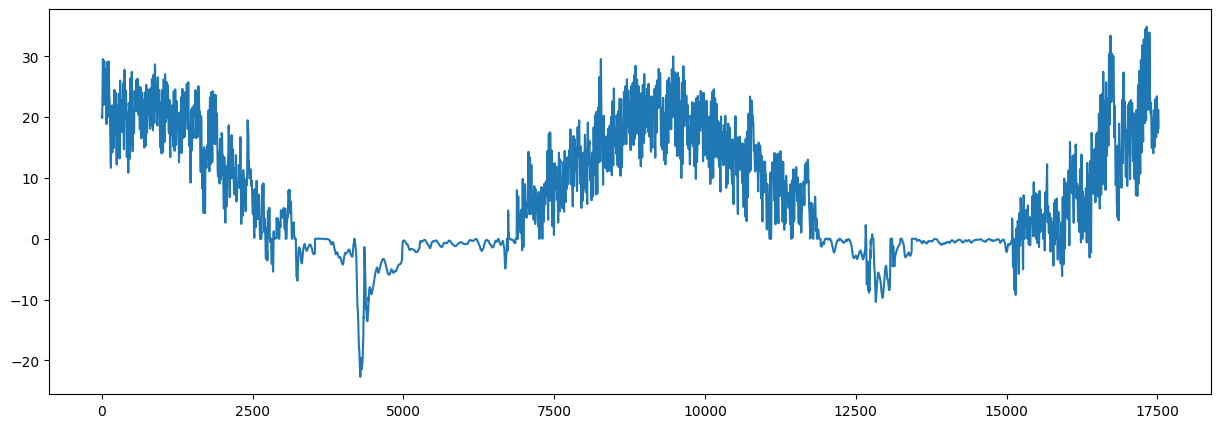

In [36]:
from matplotlib import pyplot as plt
test_svs.dfhourly_out["TPSOIL_1"].sub(273.15).plot(figsize=(15, 5))
plt.show()


# Creating ensemble scenarios


In [5]:
#  >>> p_scn_dict = dict(
#     ...     scenario_1 = {'sand': [10, 10, 10], 'clay': [4, 4, 4, 4]}
#             scenario_2 = {'sand': [14, 14, 14], 'clay': [6, 6, 6, 6]}
#     ... )

# random number generator
drng = np.random.default_rng(RND_SEED)

# we only perturb `sand` and `clay` parameters
sand_range = (50, 70)
clay_range = (5, 10)

# number of soil layers defined in the layering information
n_layers = input_object_deterministic.soilcover_info.shape[0]


scenarios = {}
for ith_scn in range(ENS_SIZE):

    # assumes soil column is homogeneous
    scenarios[f"scenario_{ith_scn}"] = {
        'sand': np.full(n_layers, drng.uniform(*sand_range)).round(2),
        'clay': np.full(n_layers, drng.uniform(*clay_range)).round(2),
    }


# run the ensemble simulation


In [7]:
ensemble_object = PerturbAndRun(
    input_object_deterministic, scenarios, njobs=N_PROCS
);
ensemble_object.create_param_scen_df()


the SVS instance modified based on scenario scenario_0.

the SVS instance modified based on scenario scenario_1.

the SVS instance modified based on scenario scenario_2.

the SVS instance modified based on scenario scenario_3.

the SVS instance modified based on scenario scenario_4.

the SVS instance modified based on scenario scenario_5.

the SVS instance modified based on scenario scenario_6.

the SVS instance modified based on scenario scenario_7.

the SVS instance modified based on scenario scenario_8.

the SVS instance modified based on scenario scenario_9.



In [18]:
test_svs.mesh_param_file.parameters.keys()


dict_keys(['sand', 'clay', 'wsat', 'wfc', 'wwilt', 'ksat', 'psisat', 'bcoef', 'rhosoil', 'deglat', 'deglng', 'slop', 'zusl', 'ztsl', 'observed_forcing', 'draindens', 'vf_type', 'nsoil_layers', 'SCHMSOL', 'lsoil_freezing_svs1', 'soiltext', 'read_user_parameters', 'save_minutes_csv', 'water_ponding', 'KFICE', 'OPT_SNOW', 'OPT_FRAC', 'OPT_LIQWAT', 'WAT_REDIS', 'tperm', 'user_wfcdp'])

In [26]:
ensemble_object.run_all_parallel()


Running scenario_0 SVS instance ...

Running scenario_1 SVS instance ...

Running scenario_2 SVS instance ...

Running scenario_3 SVS instance ...

Waiting for the 4 processes to finish ...
Finished!

Running scenario_4 SVS instance ...

Running scenario_5 SVS instance ...

Running scenario_6 SVS instance ...

Running scenario_7 SVS instance ...

Waiting for the 4 processes to finish ...
Finished!

Running scenario_8 SVS instance ...

Running scenario_9 SVS instance ...

Waiting for the last 2 process(es) to finish ...
Finished!



,DRAI,ET,PCP,OVFLW,WSOIL_1,WSOIL_2,WSOIL_3,WSOIL_4,WSOIL_5,WSOIL_6,...,TSNO_1,TSNO_2,SNVMA,SNVDP,SNVDEN,SNVALB,WSNV,TSNV_1,TSNV_2,member
date,,,,,,,,,,,,,,,,,,,,,
2019-07-01,0.2813,3.6191,0.000,0.0,0.091892,0.096226,0.098386,0.099163,0.098875,0.097677,...,300.0,300.0,0.0,0.0,150.0,0.8,0.0,300.0,300.0,scenario_0
2019-07-02,0.2643,3.7906,0.000,0.0,0.078900,0.085280,0.088551,0.090297,0.091014,0.090942,...,300.0,300.0,0.0,0.0,150.0,0.8,0.0,300.0,300.0,scenario_0
2019-07-03,0.2629,3.6882,0.000,0.0,0.067018,0.076165,0.080560,0.083058,0.084395,0.084926,...,300.0,300.0,0.0,0.0,150.0,0.8,0.0,300.0,300.0,scenario_0
2019-07-04,0.2461,3.8618,0.000,0.0,0.055249,0.068603,0.073973,0.076992,0.078713,0.079611,...,300.0,300.0,0.0,0.0,150.0,0.8,0.0,300.0,300.0,scenario_0
2019-07-05,0.2457,3.3973,0.400,0.0,0.042820,0.061844,0.068290,0.071758,0.073747,0.074882,...,300.0,300.0,0.0,0.0,150.0,0.8,0.0,300.0,300.0,scenario_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-25,0.0879,3.9400,0.000,0.0,0.098027,0.103357,0.105207,0.104407,0.100907,0.093819,...,300.0,300.0,0.0,0.0,150.0,0.8,0.0,300.0,300.0,scenario_9
2020-06-26,0.0879,4.2290,0.000,0.0,0.073517,0.084066,0.087399,0.088044,0.086611,0.082971,...,300.0,300.0,0.0,0.0,150.0,0.8,0.0,300.0,300.0,scenario_9
2020-06-27,0.0879,2.7980,0.000,0.0,0.058458,0.070369,0.075338,0.077303,0.077112,0.074958,...,300.0,300.0,0.0,0.0,150.0,0.8,0.0,300.0,300.0,scenario_9
